In [1]:
# necessary libraries
import os
import shutil
import pandas as pd
import random

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

from keras.models import Model, Sequential
from keras import layers

import tensorflow as tf

In [2]:
# Creating train and validation directories
root_directory = "/kaggle/input/ktp-nonktp"  

csv_file_path = "/kaggle/input/ktp-nonktp/annotations.csv"
annotations = pd.read_csv(csv_file_path, sep=';')

images = os.path.join(root_directory, "images")

train_directory = "train"
val_directory = "test"
os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

# Creating label directories
labels = annotations["label"].value_counts().index

for label in labels:
    label_train_directory = os.path.join(train_directory, label)
    label_val_directory = os.path.join(val_directory, label)
    os.makedirs(label_train_directory, exist_ok=True)
    os.makedirs(label_val_directory, exist_ok=True)

In [3]:
images

'/kaggle/input/ktp-nonktp/images'

In [4]:
annotations["label"].value_counts().index

Index(['KTP', 'NonKTP'], dtype='object', name='label')

In [5]:
# Shuffle the data
annotations = annotations.sample(frac=1).reset_index(drop=True)
# Split the data into 70% train and 30% validation
val_data_count = int(len(annotations) * 0.3)
validation_data = annotations[:val_data_count]
train_data = annotations[val_data_count:]

In [6]:
images

'/kaggle/input/ktp-nonktp/images'

In [7]:
# Copy train data
for index, row in train_data.iterrows():

    # file name 
    file_name = row['filename']
    # label name
    label = row["label"]

    # images folder , all images are in here  
    source_path = os.path.join(images,file_name) #
    # new destination
    destination_directory = os.path.join(train_directory, label)
    # copy files
    shutil.copy(source_path, destination_directory)
   
    
# Copy validation data
for index, row in validation_data.iterrows():
 
    file_name = row['filename']
    label = row['label']
    
    source_path = os.path.join(images, file_name)
    destination_directory = os.path.join(val_directory, label)
    shutil.copy(source_path, destination_directory)

In [8]:
# use this function for preparing data  
def prep_data(augmented,batch_size=16):      # if you want to augmented dat set use it like this : prep_data(True)
    if augmented:                            # default batch_size is 16 , you can change it 
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    
        validation_datagen = ImageDataGenerator(rescale=1./255)    

    else:
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # training set
    train_set = train_datagen.flow_from_directory(
        train_directory,
        target_size=(180, 180),  # The dimensions to which all images found will be resized
        batch_size=batch_size, # 32  default
        class_mode="binary") # you can change this to onehotEncoded format or another format
         
    
    # validation set
    validation_set = validation_datagen.flow_from_directory(
        val_directory,
        target_size=(180, 180),
        batch_size=batch_size,  # 32 default
        class_mode="binary")
             
    return train_set , validation_set

In [9]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
train_set,validation_set=prep_data(True)

Found 58 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [11]:
validation_set

In [12]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_accuracy', patience=10), ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1 , activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), # Use the BinaryCrossentropy loss function
              metrics=['accuracy'])

model1 = model.fit(
    train_set,
    epochs=35,
    validation_data=validation_set,
    callbacks=callbacks,)

Epoch 1/35
4/4 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.5345

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 6s 958ms/step - loss: 0.7372 - accuracy: 0.5345 - val_loss: 0.6811 - val_accuracy: 0.4583
Epoch 2/35
4/4 [==============================] - 3s 809ms/step - loss: 0.7148 - accuracy: 0.4483 - val_loss: 0.6937 - val_accuracy: 0.5417
Epoch 3/35
4/4 [==============================] - 4s 853ms/step - loss: 0.6973 - accuracy: 0.4655 - val_loss: 0.6811 - val_accuracy: 0.5417
Epoch 4/35
4/4 [==============================] - 3s 829ms/step - loss: 0.6809 - accuracy: 0.6207 - val_loss: 0.6752 - val_accuracy: 0.5417
Epoch 5/35
4/4 [==============================] - 3s 709ms/step - loss: 0.6601 - accuracy: 0.7414 - val_loss: 0.6621 - val_accuracy: 0.5417
Epoch 6/35
4/4 [==============================] - 3s 925ms/step - loss: 0.6377 - accuracy: 0.7414 - val_loss: 0.6301 - val_accuracy: 0.7500
Epoch 7/35
4/4 [==============================] - 3s 910ms/step - loss: 0.6187 - accuracy: 0.7241 - val_loss: 0.5913 - val_accuracy: 0.7917
Epoch 8/35
4/4 [===============

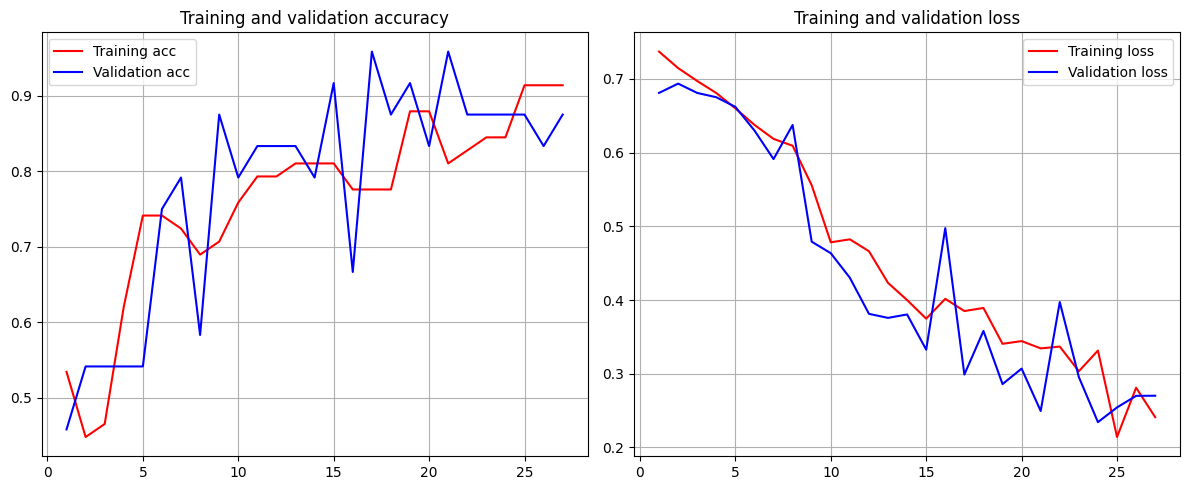

In [13]:
visualize(model1)

In [14]:
# importing pretrained models 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception

In [31]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

# Freeze the layers except the last few layers
for layer in base_model.layers[:-18]:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(), # Use the BinaryCrossentropy loss function
              metrics=['accuracy'])

model2 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    callbacks=callbacks,)

Epoch 1/40
4/4 [==============================] - 14s 2s/step - loss: 1.0000 - accuracy: 0.6034 - val_loss: 0.1113 - val_accuracy: 0.9167
Epoch 2/40
4/4 [==============================] - 4s 1s/step - loss: 0.2823 - accuracy: 0.8966 - val_loss: 0.0891 - val_accuracy: 0.9583
Epoch 3/40
4/4 [==============================] - 4s 1s/step - loss: 0.1305 - accuracy: 0.9655 - val_loss: 2.2129e-04 - val_accuracy: 1.0000
Epoch 4/40
4/4 [==============================] - 4s 937ms/step - loss: 0.2694 - accuracy: 0.9310 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 5/40
4/4 [==============================] - 3s 819ms/step - loss: 0.2995 - accuracy: 0.9483 - val_loss: 3.8260e-04 - val_accuracy: 1.0000
Epoch 6/40
4/4 [==============================] - 4s 1s/step - loss: 0.2577 - accuracy: 0.9483 - val_loss: 2.0595e-06 - val_accuracy: 1.0000
Epoch 7/40
4/4 [==============================] - 4s 949ms/step - loss: 0.3417 - accuracy: 0.9138 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/40
4/4 [===

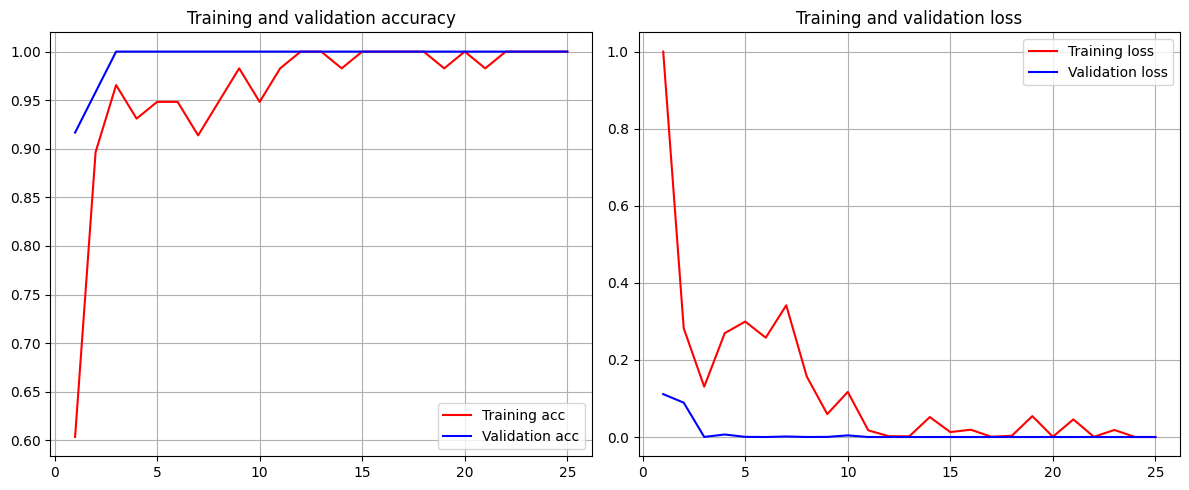

In [32]:
visualize(model2)

In [25]:
from keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np


In [33]:
final_model = load_model('best_model.h5')

In [34]:
# Load the image you want to predict
img = image.load_img("/kaggle/input/ktp-nonktp/images/59.jpg", target_size=(180,180))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to fit the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array /= 255.

In [35]:
# Use the model to predict the image
predictions = final_model.predict(img_array)

# The model returns a probability for each class. 
# You can use np.argmax() to get the index of the highest probability.
predicted_class = np.argmax(predictions[0])

print(f"The model predicts class {predicted_class} for the input image.")

1/1 [==============================] - 2s 2s/step
The model predicts class 0 for the input image.


In [29]:
predictions

array([[0.989736]], dtype=float32)

In [30]:
# Specify the path to your folder
folder_path = '/kaggle/input/dataset-ktp/test'

# Initialize a list to store your images
images = []

# Loop over every file in the folder
for file in os.listdir(folder_path):
    # Only work with files with the extensions .png, .jpg, .jpeg
    if file.endswith(('.png', '.jpg', '.jpeg')):
        # Load the image file
        img_path = os.path.join(folder_path, file)
        img = image.load_img(img_path, target_size=(180, 180))

        # Convert the image to a numpy array and preprocess it
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.

        # Add the image to the list of images
        images.append(img_array)

# Convert the list of images to a single numpy array
images = np.vstack(images)

# Use the model to predict the class of each image
predictions = final_model.predict(images)

# Since this is a binary classification, the prediction will be a float between 0 and 1.
# You can convert this probability into a class label by using a threshold.
# Here we use 0.5 as the threshold.
predicted_classes = (predictions > 0.5).astype(int)

print(f"The model predicts classes {predicted_classes} for the input images.")

1/1 [==============================] - 1s 927ms/step
The model predicts classes [[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]] for the input images.
